In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import Tensor

from typing import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In this set of exercises, we'll be building up towards a tensor that holds the kinematic properties of a batch of muons, that move in 3D.

## Initial sampling
### Position
First, create a (100,3) tensor, called `muons`, of initial positions for 100 muons in (x,y,z), such that `x~Uniform[0,10]`, `y~Uniform[0,5]`, and `z=8`.

In [4]:
# your code goes here

In [5]:
n_muons = 100
muons = torch.rand(n_muons,3)
muons[:,0] *= 10
muons[:,1] *= 5
muons[:,2] = 8

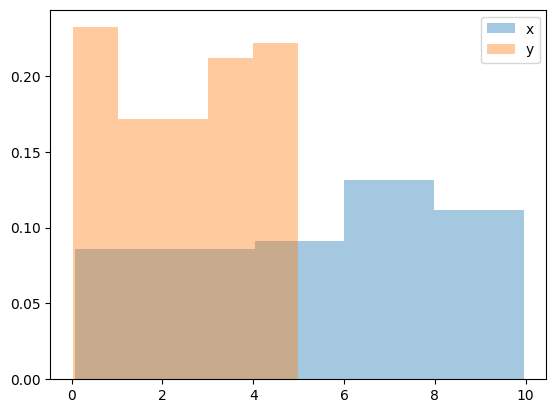

In [6]:
sns.distplot(muons[:,0], label='x', kde=False, norm_hist=True)
sns.distplot(muons[:,1], label='y', kde=False, norm_hist=True)
plt.legend()

In [7]:
assert (muons > 0).all()
assert (muons[:,0] < 10).all()
assert (muons[:,1] < 5).all()
assert (muons[:,2] == 8).all()
assert len(muons) == 100

### Angle
Now include in the muon tensor the theta and phi angle of the direction of travel of the muon. Theta is the angle from the positive direction of the z-axis, $\theta\sim[0,\pi)$, and phi is the azimuthal angle in the xy plane, starting from the positive x-axis and increasing towards the positive y-axis, $\phi\sim[0,2\pi)$, as shown below:

<img src="imgs/3D_Spherical.svg.png" width="20%"/>

*Image by [Andeggs - Own work, Public Domain](https://commons.wikimedia.org/w/index.php?curid=7478049)*

The phi angle should be sampled uniformly, and theta should be sampled according to the absolute value of a Gaussian with mean zero and sigma pi/4.
The final `muons` tensor should be of shape (10,5) corresponding to (x,y,z,theta,phi).

In [8]:
# your code goes here

In [9]:
theta = torch.abs(torch.randn(len(muons),1)*torch.pi/4).clamp_max(torch.pi)
phi = torch.rand(len(muons),1)*2*torch.pi

In [10]:
muons = torch.cat((muons, theta, phi), dim=-1)

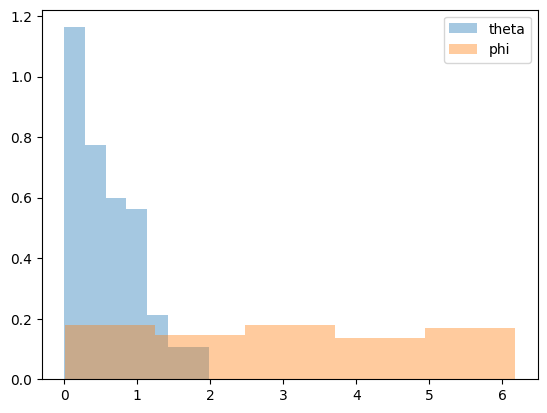

In [11]:
sns.distplot(muons[:,-2], label='theta', kde=False, norm_hist=True)
sns.distplot(muons[:,-1], label='phi', kde=False, norm_hist=True)
plt.legend()

In [12]:
assert (muons > 0).all()
assert (muons[:,3] < torch.pi).all()
assert (muons[:,4] < 2*torch.pi).all()
assert len(muons) == 100

## Propagation
Write a function that will update the muon positions after they have all travelled a certain distance along their direction of travel. The distance can either be the same for every muon (provided as a float), or each muon can be provided with its own distance travel, in the form of a (100,1) tensor.

Decomposing a distance r in spherical coordinates to Cartesian coordinates is:
$$z = r\cos\theta$$
$$x = r\sin\theta\cos\phi$$
$$y = r\sin\theta\sin\phi$$

The `propagate` function should update the muon positions internally, rather that returning the distances travelled.

In [13]:
def propagate(muons:Tensor, distances:Union[float,Tensor]) -> None:
    # your code goes here
    
    muons[:,2] = muons[:,2]+(distances*torch.cos(muons[:,3]))
    rst = distances*torch.sin(muons[:,3])
    muons[:,0] = muons[:,0]+(rst*torch.cos(muons[:,4]))    
    muons[:,1] = muons[:,1]+(rst*torch.sin(muons[:,4]))      

In [14]:
test = Tensor([[0,0,0,0,0], [0,0,0,torch.pi/4,0], [0,0,0,torch.pi/2,torch.pi*3/4], [0,0,0,torch.pi*3/4,torch.pi/2]])

In [15]:
propagate(test, 1)

In [16]:
assert ((test - Tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 7.0711e-01,  0.0000e+00,  7.0711e-01,  7.8540e-01,  0.0000e+00],
        [-7.0711e-01,  7.0711e-01, -4.3711e-08,  1.5708e+00,  2.3562e+00],
        [-3.0909e-08,  7.0711e-01, -7.0711e-01,  2.3562e+00,  1.5708e+00]])).abs() < 1e-3).all()

In [17]:
propagate(test, Tensor([0,1,-2,3.5]))

In [18]:
assert ((test - Tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4142e+00,  0.0000e+00,  1.4142e+00,  7.8540e-01,  0.0000e+00],
        [ 7.0711e-01, -7.0711e-01,  4.3711e-08,  1.5708e+00,  2.3562e+00],
        [-1.3909e-07,  3.1820e+00, -3.1820e+00,  2.3562e+00,  1.5708e+00]])).abs() < 1e-3).all()

## Masking
Use Boolean masking to remove any muons with a theta angle greater than of equal to pi/2.

In [20]:
# your code goes here

In [21]:
muons = muons[muons[:,3] < torch.pi/2]

In [23]:
len(muons)

95

Now compute the mean values of all the muon properties

In [24]:
# your code goes here

In [25]:
muons.mean(0)

tensor([5.2920, 2.5366, 8.0000, 0.5297, 2.9780])